In [111]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
X_test = pd.read_csv('X_test_GgyECq8.csv')
X_train = pd.read_csv('X_train_Wwou3IE.csv')
y_train = pd.read_csv('y_train_jJtXgMX.csv')
y_pred = pd.read_csv('y_random_pt8afo8.csv')

In [113]:
X_train.columns

Index(['DELIVERY_START', 'load_forecast', 'coal_power_available',
       'gas_power_available', 'nucelear_power_available',
       'wind_power_forecasts_average', 'solar_power_forecasts_average',
       'wind_power_forecasts_std', 'solar_power_forecasts_std',
       'predicted_spot_price'],
      dtype='object')

In [114]:
y_train.columns

Index(['DELIVERY_START', 'spot_id_delta'], dtype='object')

In [115]:
round(X_train.isna().sum()/X_train.shape[0]*100,2)

DELIVERY_START                    0.00
load_forecast                    12.14
coal_power_available              0.01
gas_power_available               0.01
nucelear_power_available          0.01
wind_power_forecasts_average      0.23
solar_power_forecasts_average     0.23
wind_power_forecasts_std          0.23
solar_power_forecasts_std         0.23
predicted_spot_price             82.59
dtype: float64

In [116]:
round(X_test.isna().sum()/X_test.shape[0]*100,2)

DELIVERY_START                    0.00
load_forecast                     0.00
coal_power_available              0.00
gas_power_available               0.00
nucelear_power_available          0.00
wind_power_forecasts_average      0.00
solar_power_forecasts_average     0.49
wind_power_forecasts_std          0.00
solar_power_forecasts_std         0.49
predicted_spot_price             31.08
dtype: float64

In [117]:
def compute_weighted_accuracy(y_actual, y_pred):
    # If y_actual is a DataFrame, extract the 'spot_id_delta' column, otherwise assume it's already a numpy array
    if isinstance(y_actual, pd.DataFrame):
        actual = y_actual["spot_id_delta"].values
    else:
        actual = y_actual
    
    # If y_pred is a DataFrame, extract the 'spot_id_delta' column, otherwise assume it's already a numpy array
    if isinstance(y_pred, pd.DataFrame):
        predicted = y_pred["spot_id_delta"].values
    else:
        predicted = y_pred
    
    # actual = y_actual["spot_id_delta"].values
    # predicted = y_pred["spot_id_delta"].values

    correct_direction = (np.sign(actual) == np.sign(predicted)).astype(int)

    weights = np.abs(actual)

    weighted_accuracy = np.sum(correct_direction * weights) / np.sum(weights)

    return round(weighted_accuracy, 2)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
------------------------------------------------------------------------------------------------------
Best Model: RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=42)
Train Metrics - MSE: 1124.3757392238438 MAE: 20.34409895047519 Weighted Accuracy: 0.69
Validation Metrics - MSE: 1800.3050890113182 MAE: 27.372928804255558 Weighted Accuracy: 0.75
------------------------------------------------------------------------------------------------------
Test Metrics - MSE: 2022.5717413425832 MAE: 17.182638849735348 Weighted Accuracy: 0.46


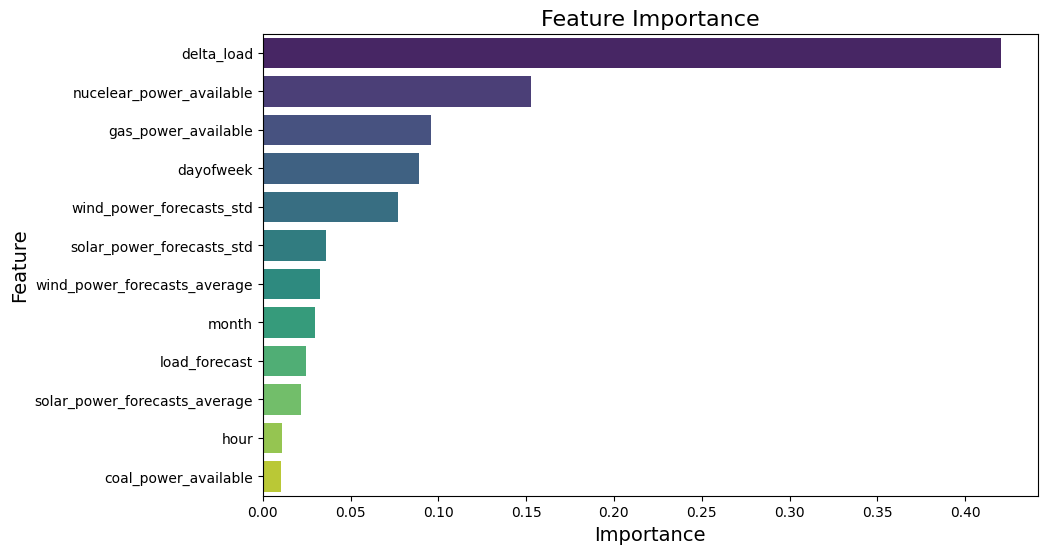

In [118]:
def preprocess_data(df):
    # Ensure 'DELIVERY_START' is set as the index with timezone handling
    if 'DELIVERY_START' in df.columns:
        df['DELIVERY_START'] = pd.to_datetime(df['DELIVERY_START'], utc=True)  # Parse with timezone info
        df = df.set_index('DELIVERY_START')
        df.index = df.index.tz_convert('Europe/Berlin')  # Adjust to desired timezone, if needed

    # Add time-related features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    # Handle missing values, encode categoricals, etc.
    df = df.fillna(0)  # Fill missing values with 0 (adjust as needed)
    df = pd.get_dummies(df, drop_first=True)  # Encode categorical variables

    # Drop unwanted columns
    df = df.drop(columns=['predicted_spot_price'], errors='ignore')

    df['delta_load'] = df['load_forecast'] - (df['coal_power_available']+df['gas_power_available']+
                                              df['nucelear_power_available']+df['wind_power_forecasts_average']+
                                              df['solar_power_forecasts_average'])

    return df

def preprocess_y(y):
    # Ensure 'DELIVERY_START' is set as the index
    if 'DELIVERY_START' in y.columns:
        y['DELIVERY_START'] = pd.to_datetime(y['DELIVERY_START'], utc=True)  # Parse with timezone info
        y = y.set_index('DELIVERY_START')
        y.index = y.index.tz_convert('Europe/Berlin')  # Adjust to desired timezone
    return y

def split_train_data(X, y):
    # Ensure indices align during split
    split_size = len(X) // 3
    X_train1, X_train2, X_train3 = X.iloc[:split_size], X.iloc[split_size:2*split_size], X.iloc[2*split_size:]
    y_train1, y_train2, y_train3 = y.iloc[:split_size], y.iloc[split_size:2*split_size], y.iloc[2*split_size:]
    return X_train1, X_train2, X_train3, y_train1, y_train2, y_train3

def train_model(X_train, y_train):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train.values.ravel())  # Ensure y is passed as a 1D array
    return model

def evaluate_model(model, X, y_actual):
    # Predict on the given dataset
    predictions = model.predict(X)
    
    # Compute regression metrics
    mse = mean_squared_error(y_actual, predictions)
    mae = mean_absolute_error(y_actual, predictions)
    
    # Use custom weighted accuracy
    y_pred_df = pd.DataFrame(predictions, index=X.index, columns=["spot_id_delta"])
    weighted_acc = compute_weighted_accuracy(y_actual, y_pred_df)
    
    return mse, mae, weighted_acc

def tune_hyperparameters(X_train2, y_train2):
    # Flatten y_train2 to 1D array
    y_train2 = y_train2.values.ravel()  # Ensure y is 1D array
    # Define the model
    rf_model = RandomForestRegressor(random_state=42)

    # Set up the hyperparameter grid
    param_grid = {
        'n_estimators': [200, 500, 1000],
        'max_depth': [5, 10],
    }

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    
    grid_search.fit(X_train2, y_train2)

    # Return the best model and parameters
    return grid_search.best_estimator_, grid_search.best_params_

def plot_feature_importance(model, feature_names):
    # Get the feature importance values from the trained model
    feature_importances = model.feature_importances_
    
    # Create a DataFrame with the feature names and importance values
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    
    # Sort the DataFrame by importance value in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the horizontal barplot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.show()

def launch(X_train, y_train, X_test):
    # Preprocess X_train and X_test
    X_train = preprocess_data(X_train)
    features = X_train.columns
    X_test = preprocess_data(X_test)

    # Preprocess y_train (only index adjustment)
    y_train = preprocess_y(y_train)

    # Split data into 3 parts
    X_train1, X_train2, X_train3, y_train1, y_train2, y_train3 = split_train_data(X_train, y_train)

    # Tune hyperparameters using the validation set (X_train2 and y_train2)
    best_model, best_params = tune_hyperparameters(X_train2, y_train2)

    # Train the model on the full training set (X_train1 + X_train2)
    X_train_full = pd.concat([X_train1, X_train2])
    y_train_full = pd.concat([y_train1, y_train2])

    # Flatten y_train_full to 1D array
    y_train_full = y_train_full.values.ravel()  # Ensure y is 1D array

    # Train the model on the full training data
    best_model.fit(X_train_full, y_train_full)

    # Evaluate the model on the full training data (X_train_full)
    train_mse, train_mae, train_weighted_acc = evaluate_model(best_model, X_train_full, y_train_full)

    # Validate on the validation set (X_train2, y_train2)
    val_mse, val_mae, val_weighted_acc = evaluate_model(best_model, X_train2, y_train2)

    # Test on the test set (X_train3, y_train3)
    test_mse, test_mae, test_weighted_acc = evaluate_model(best_model, X_train3, y_train3)

    # Apply model to the actual test dataset
    predictions_test = best_model.predict(X_test)
    y_pred_test = pd.DataFrame(predictions_test, index=X_test.index, columns=["spot_id_delta"])

    return features, best_model, (train_mse, train_mae, train_weighted_acc), (val_mse, val_mae, val_weighted_acc), (test_mse, test_mae, test_weighted_acc), y_pred_test

# Execute the pipeline
features, model, train_metrics, val_metrics, test_metrics, y_pred_test = launch(X_train, y_train, X_test)

# Print evaluation results
print('------------------------------------------------------------------------------------------------------')
print("Best Model:", model)
print("Train Metrics - MSE:", train_metrics[0], "MAE:", train_metrics[1], "Weighted Accuracy:", train_metrics[2])
print("Validation Metrics - MSE:", val_metrics[0], "MAE:", val_metrics[1], "Weighted Accuracy:", val_metrics[2])
print('------------------------------------------------------------------------------------------------------')
print("Test Metrics - MSE:", test_metrics[0], "MAE:", test_metrics[1], "Weighted Accuracy:", test_metrics[2])

# Call the function with the trained model and your data
plot_feature_importance(model, features)

# Save predictions
y_pred_test.to_csv('y_pred_test.csv', index=False)